In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import Simulation_wells as sw
from matplotlib.lines import Line2D

In [2]:


par_values = [
    0.5,     # wgl1
    0.7,     # wgl2
    1,     # u1
    1,     # u2
    0.02,     # GOR1
    0.02     # GOR2
]

# --- Condições Iniciais [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500,
                           3500, 3500, 117.97660766, 795.94318092]

# --- Configuração do Tempo ---
t0 = 0
tf = 25000  # Tempo final [s]
dt = 5      # Passo de tempo [s]
t = np.arange(t0, tf, dt)

# --- Configuração do Integrador CasADi ---
x_sym = ca.SX.sym('x', 8)  # Vetor de 8 estados
par_sym = ca.SX.sym('par', 6) # Vetor de 6 parâmetros

# Define a expressão da EDO
dx_sym = sw.fun(0, x_sym, par_sym)

#Cria o integrador
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)


x_current = np.array(y0)
results = {key: [] for key in sw.modelo(y0, par_values).keys()}


for ti in t:

    res = integrator(x0=x_current, p=par_values)
    x_next = res['xf'].full().flatten()

    model_output = sw.modelo(x_next, par_values)
    
    for key in results:
        results[key].append(float(model_output[key]))
    
    x_current = x_next

for key in results:
    results[key] = np.array(results[key])


#

CasADi - 2025-08-05 01:40:31 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


--- Calculando mapa para GOR1 = 0.010 ---
0.7 0.2
0.8 0.2
0.9000000000000001 0.2
1.0 0.2
0.8 0.4
0.9000000000000001 0.4
1.0 0.4
1.0 0.6000000000000001
--- Calculando mapa para GOR1 = 0.030 ---
0.8 0.2
0.9000000000000001 0.2
1.0 0.2
0.9000000000000001 0.4
1.0 0.4
--- Calculando mapa para GOR1 = 0.050 ---
0.9000000000000001 0.2
1.0 0.2
--- Calculando mapa para GOR1 = 0.080 ---


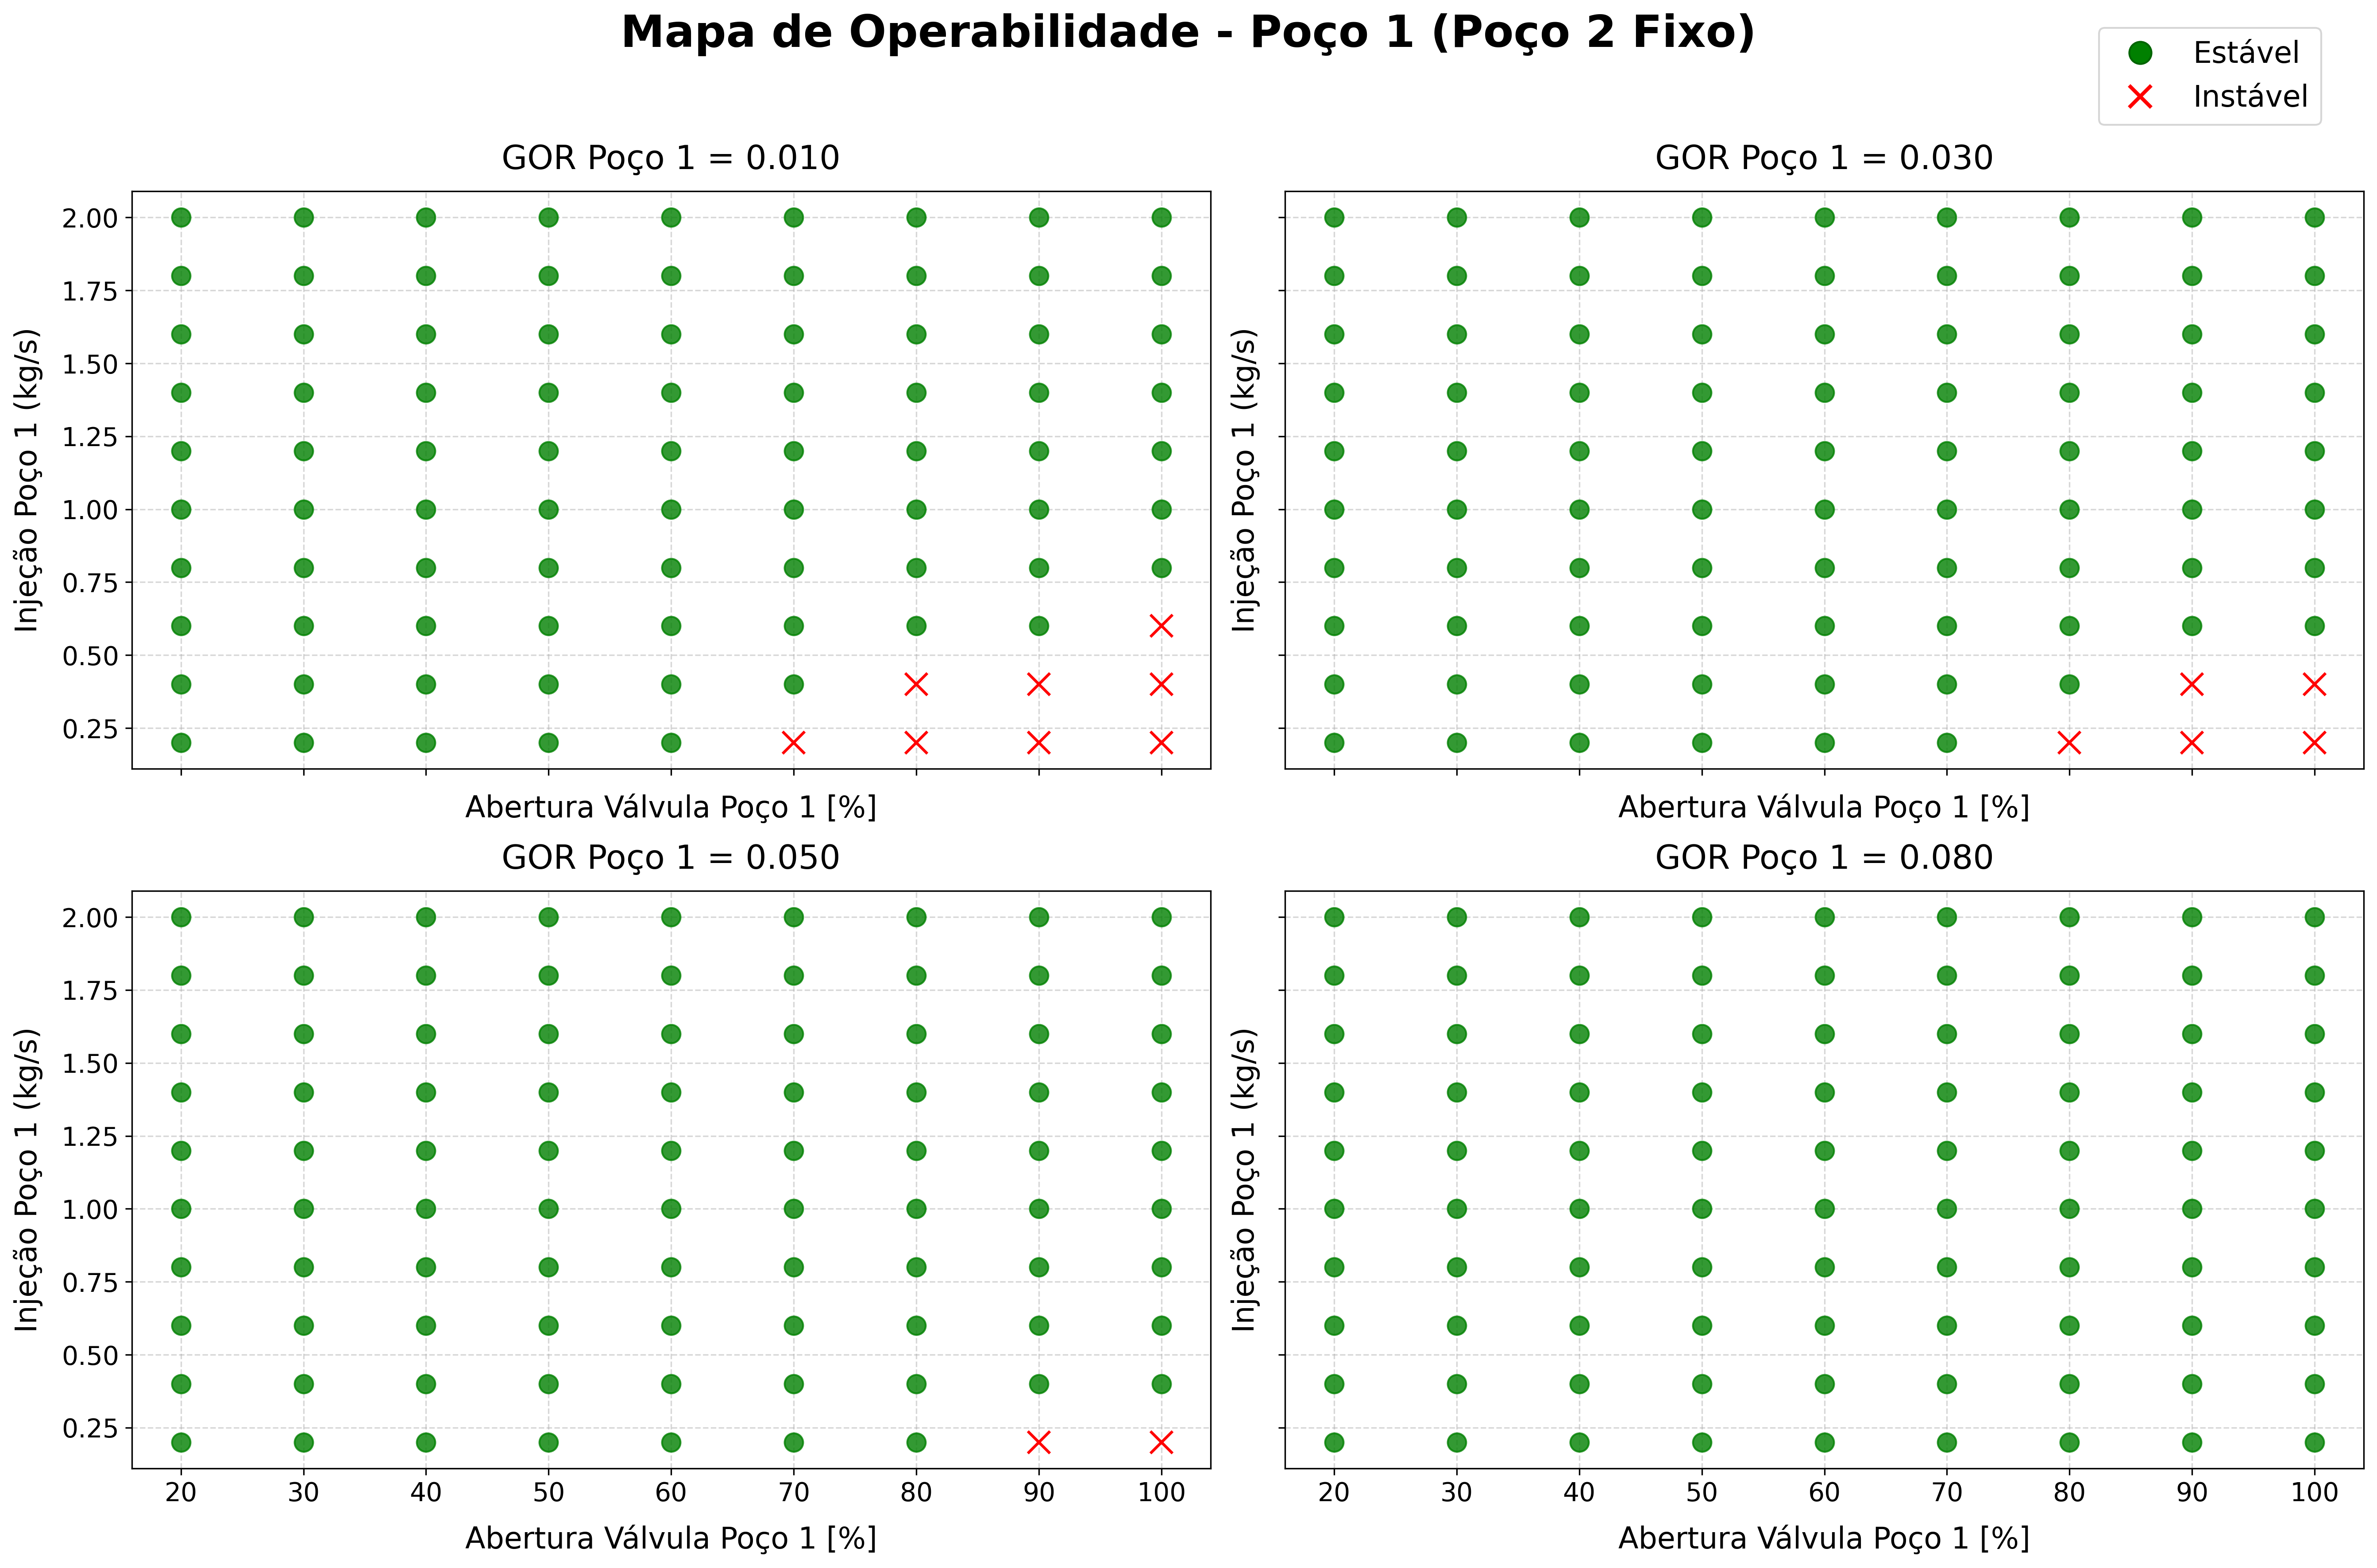

In [3]:
wgl1_rates = np.linspace(0.2, 2.0, 10)      
u1_openings = np.linspace(0.2, 1.0, 9)     
GOR1_values = [0.01, 0.03, 0.05, 0.08]      

# Parâmetros FIXOS para o Poço 2 
wgl2_fixed = 0.7   
u2_fixed = 1.0     
GOR2_fixed = 0.1  

# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]

# --- Configuração do Tempo e Critério de Convergência ---
tf = 30000         # Tempo final da simulação para cada ponto [s]
dt = 5           # Passo de tempo [s]
t = np.arange(0, tf, dt)
tolerance = 1e-7# Tolerância para considerar o sistema estável (variação na massa de gás)


x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)

dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)

# Configuração da Figura para os Mapas

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

# --- Cria a figura com alta resolução (DPI) ---
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Mapa de Operabilidade - Poço 1 (Poço 2 Fixo)', fontsize=24, weight='bold')

passos = 3
contador = 0

for idx, gor1_val in enumerate(GOR1_values):
    print(f"--- Calculando mapa para GOR1 = {gor1_val:.3f} ---")
    stability_map = np.zeros((len(wgl1_rates), len(u1_openings)))

    for i, wgl1 in enumerate(wgl1_rates):
        for j, u1 in enumerate(u1_openings):
            par_values = [wgl1, wgl2_fixed, u1, u2_fixed, gor1_val, GOR2_fixed]
            x_current = np.array(y0)
            stable_found = False

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()

               
                delta = np.abs( x_current[6] - x_next[6])


                if delta <= tolerance:
                    contador += 1  
                else:
                    contador = 0   
                if contador >= passos:
                    stable_found = True
                  
                    break
                    
                x_current = x_next
            
            stability_map[i, j] = 1 if stable_found else 0
    
            if stability_map[i,j] == 0:
               
               print(u1,wgl1)
               
    ax = axs[idx]
    for i, wgl1 in enumerate(wgl1_rates):
        for j, u1 in enumerate(u1_openings):
            u1_pct = u1 * 100
            if stability_map[i, j] == 1:
                ax.plot(u1_pct, wgl1, 'o', color='green', markersize=10, alpha=0.8,zorder=3)
            else:
                ax.plot(u1_pct, wgl1, 'x', color='red', markersize=12, mew=1.5, zorder=5)

    ax.set_title(f"GOR Poço 1 = {gor1_val:.3f}", fontsize=18, pad=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax = axs[idx]
    ax.tick_params(axis='both', labelsize=14)

for ax in axs.flat:
    ax.set_xlabel("Abertura Válvula Poço 1 [%]", fontsize=16, labelpad=10)
    ax.set_ylabel("Injeção Poço 1 (kg/s)", fontsize=16, labelpad=10)

for k in range(idx + 1, len(axs)):
    fig.delaxes(axs[k])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estável',
           markerfacecolor='green', markersize=12, markeredgecolor='darkgreen'),
    Line2D([0], [0], marker='x', color='red', label='Instável',
           markersize=12, mew=2, linestyle='None')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=16, bbox_to_anchor=(0.98, 0.98))
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


--- Calculando para GOR = 0.010 ---
--- Calculando para GOR = 0.030 ---
--- Calculando para GOR = 0.050 ---
--- Calculando para GOR = 0.080 ---


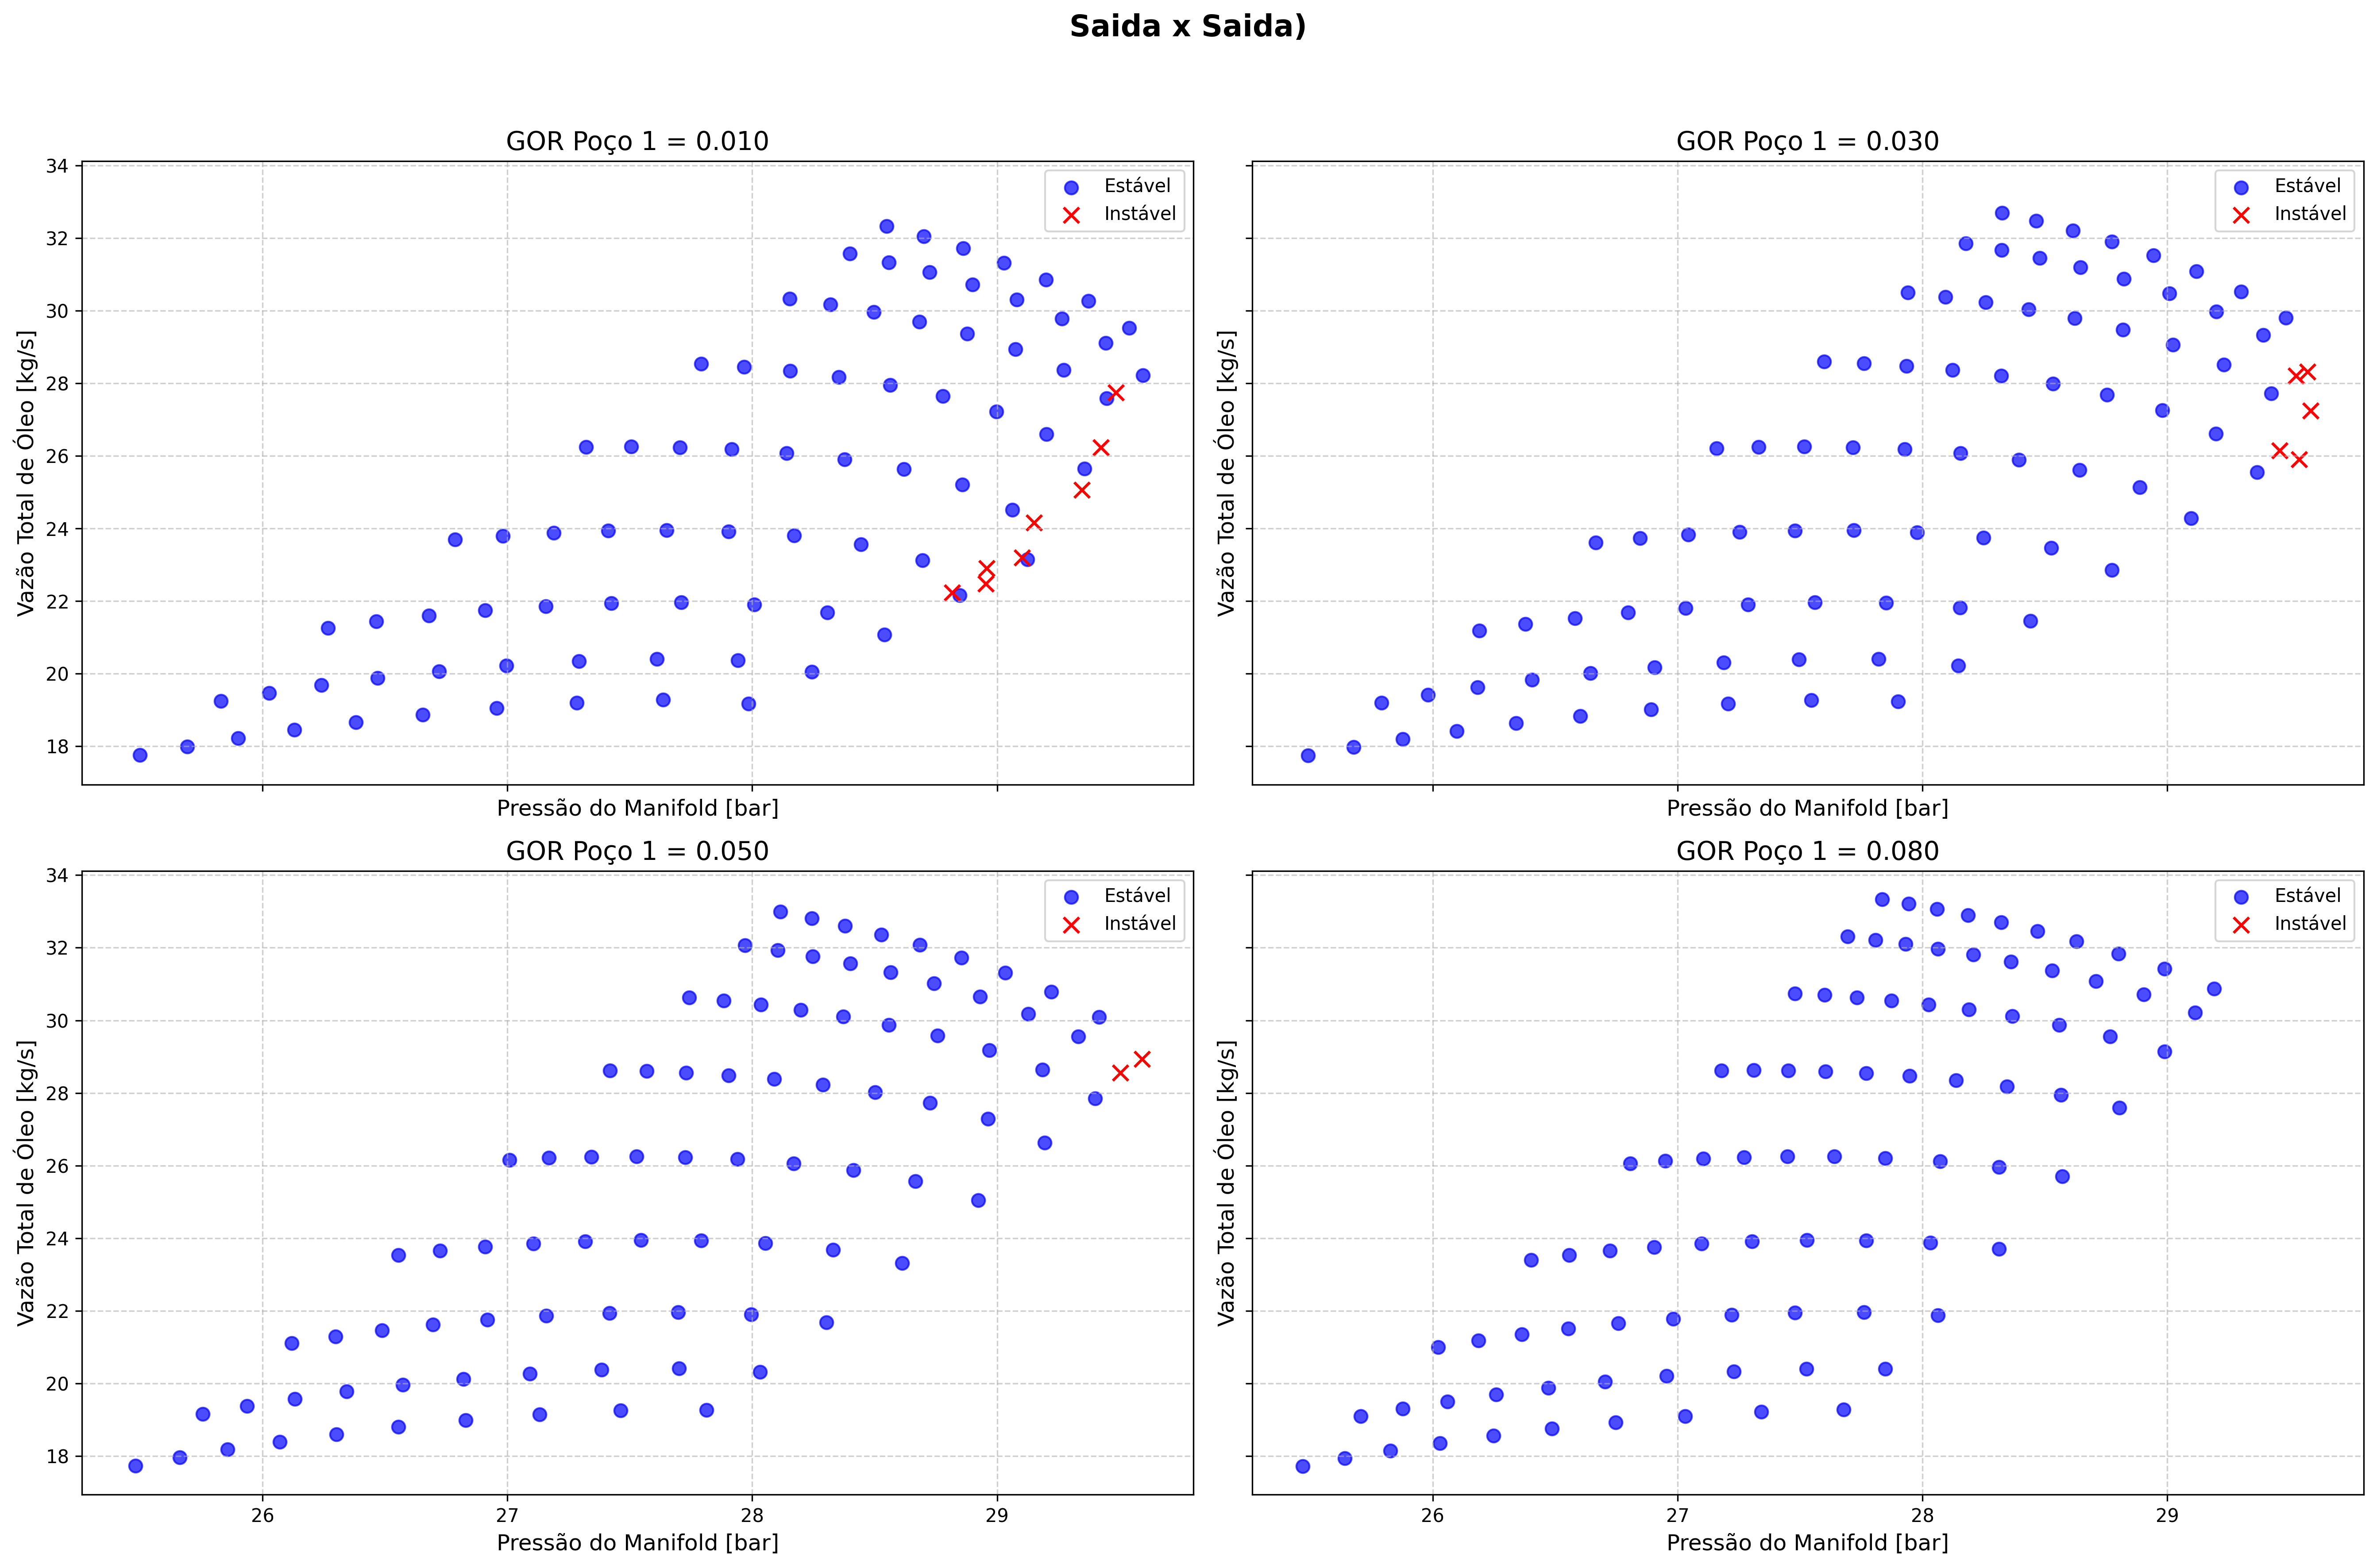

In [4]:

wgl1_rates = np.linspace(0.2, 2.0, 10)
u1_openings = np.linspace(0.2, 1.0, 9)
GOR1_values = [0.01, 0.03,0.05,0.08] 


wgl2_fixed = 0.7
u2_fixed = 1.0
GOR2_fixed = 0.1


y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]


tf = 25000
dt = 5
t = np.arange(0, tf, dt)
tolerance = 1e-6
passos = 3

x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)
dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)


resultados_finais = {}

for gor1_val in GOR1_values:
    print(f"--- Calculando para GOR = {gor1_val:.3f} ---")
    
    stability_map = np.zeros((len(wgl1_rates), len(u1_openings)))
    pm_map = np.zeros((len(wgl1_rates), len(u1_openings)))
    wpo_total_map = np.zeros((len(wgl1_rates), len(u1_openings)))

    for i, wgl1 in enumerate(wgl1_rates):
        for j, u1 in enumerate(u1_openings):
            par_values = [wgl1, wgl2_fixed, u1, u2_fixed, gor1_val, GOR2_fixed]
            x_current = np.array(y0)
            
            stable_found = False
            contador = 0
            output_history = []

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()
                model_output = sw.modelo(x_next, par_values)
                output_history.append(model_output)
                
                delta = np.abs(x_current[6] - x_next[6])
                if delta <= tolerance:
                    contador += 1
                else:
                    contador = 0
                
                if contador >= passos:
                    stable_found = True
                    break
                
                x_current = x_next

            stability_map[i, j] = 1 if stable_found else 0

            if stable_found:
                final_pm = output_history[-1]['Pm']
                final_wpo = output_history[-1]['wto_riser']
            else:
                # Calcula o índice que corresponde aos primeiros 20% do total de passos
                start_idx = int(len(output_history) * 0.8)
                final_pm = np.mean([d['Pm'] for d in output_history[start_idx:]])
                final_wpo = np.mean([d['wto_riser'] for d in output_history[start_idx:]])

            pm_map[i, j] = final_pm
            wpo_total_map[i, j] = final_wpo
            
    resultados_finais[gor1_val] = {
        'stability': stability_map,
        'Pm': pm_map,
        'wto_riser': wpo_total_map
    }


# Define a quantidade de subplots com base no número de GORs

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

# --- Cria a figura com alta resolução (DPI) ---
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Saida x Saida)', fontsize=16, weight='bold')

for idx, gor1_val in enumerate(GOR1_values):
    ax = axs[idx]
    mapas = resultados_finais[gor1_val]

    #Achata as matrizes 2D para vetores 1D 
    pm_values = mapas['Pm'].flatten()
    wpo_values = mapas['wto_riser'].flatten()
    stability_values = mapas['stability'].flatten()

    pm_stable = pm_values[stability_values == 1] / 1e5  # Converte para bar
    wpo_stable = wpo_values[stability_values == 1]
    
    pm_unstable = pm_values[stability_values == 0] / 1e5 # Converte para bar
    wpo_unstable = wpo_values[stability_values == 0]

    # Plota os pontos
    ax.scatter(pm_stable, wpo_stable, 
               s=50, color='blue', alpha=0.7, label='Estável')
    ax.scatter(pm_unstable, wpo_unstable, 
               s=70, color='red', marker='x', label='Instável')

    # Configurações do gráfico
    ax.set_title(f"GOR Poço 1 = {gor1_val:.3f}", fontsize=14)
    ax.set_xlabel("Pressão do Manifold [bar]", fontsize=12)
    ax.set_ylabel("Vazão Total de Óleo [kg/s]", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- Calculando mapa para GOR1 = 0.010 ---
0.7 0.2
0.8 0.2
0.9000000000000001 0.2
1.0 0.2
0.8 0.4
0.9000000000000001 0.4
1.0 0.4
0.9000000000000001 0.6000000000000001
1.0 0.6000000000000001
--- Calculando mapa para GOR1 = 0.030 ---
0.8 0.2
0.9000000000000001 0.2
1.0 0.2
0.9000000000000001 0.4
1.0 0.4
--- Calculando mapa para GOR1 = 0.050 ---
0.9000000000000001 0.2
1.0 0.2
--- Calculando mapa para GOR1 = 0.080 ---


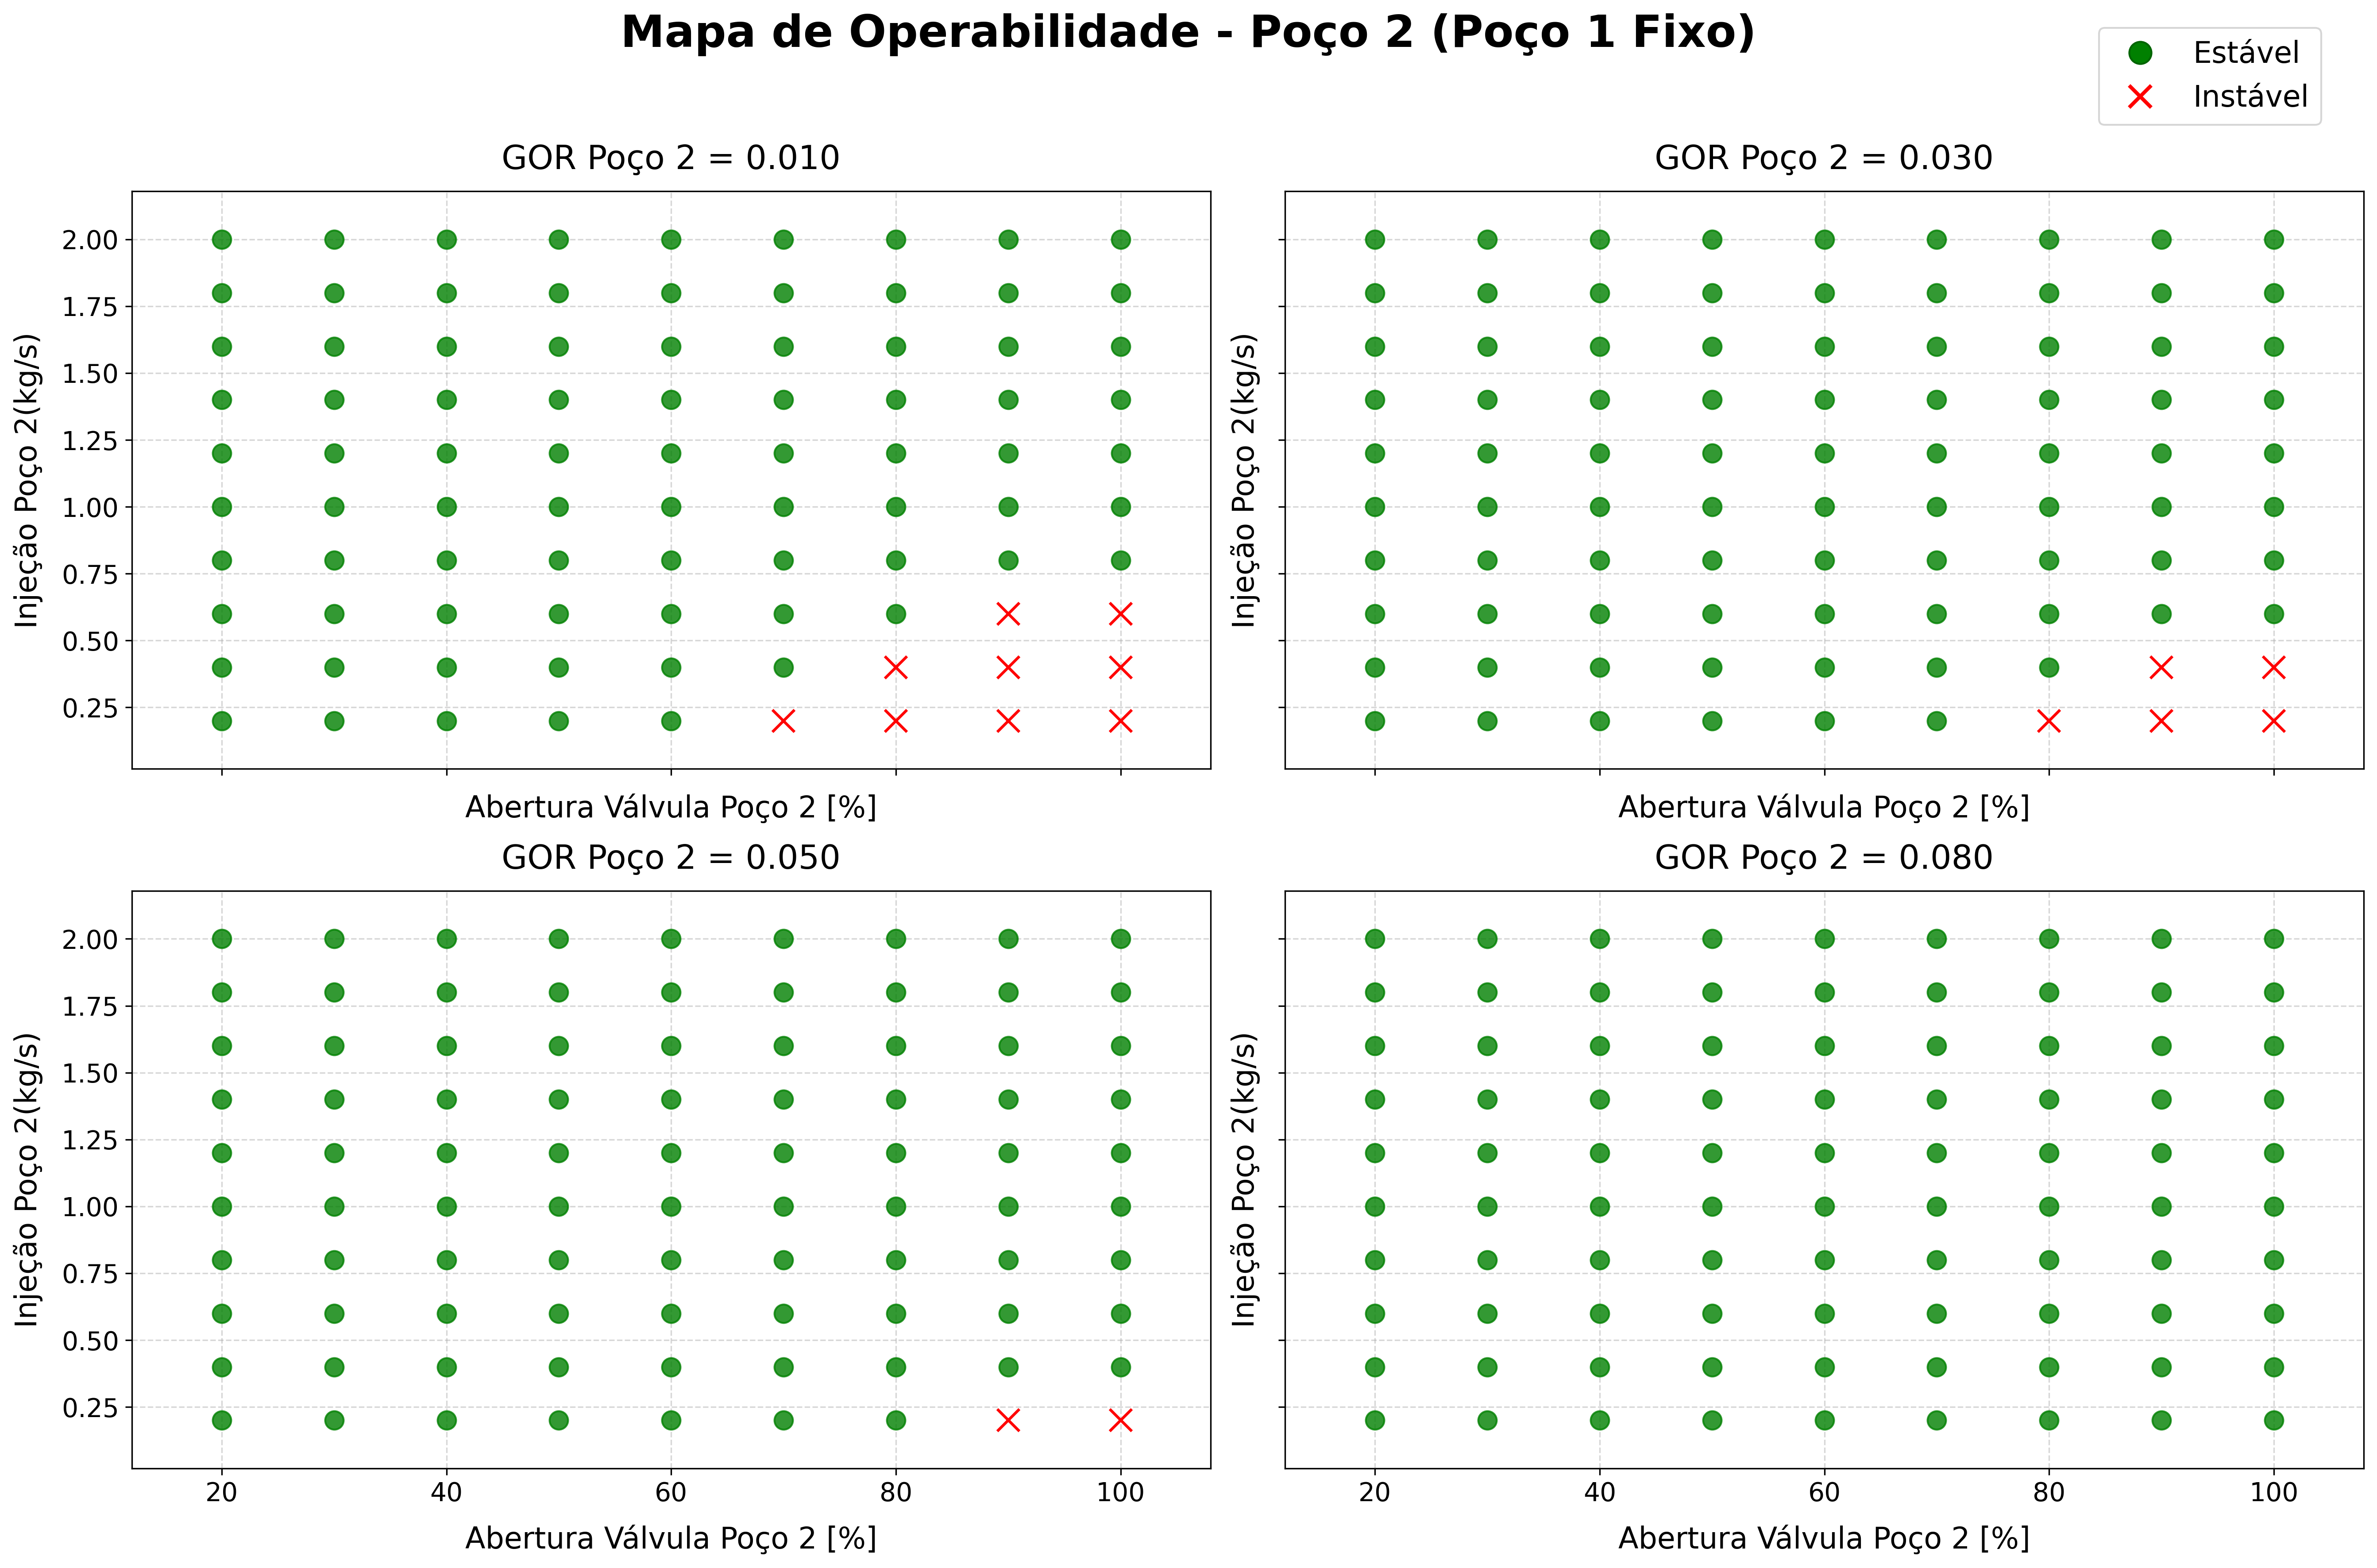

In [5]:
wgl2_rates = np.linspace(0.2, 2.0, 10)      
u2_openings = np.linspace(0.2, 1.0, 9)     
GOR2_values = [0.01, 0.03, 0.05, 0.08]      

# Parâmetros FIXOS para o Poço 2 
wgl1_fixed = 0.7   
u1_fixed = 1.0     
GOR1_fixed = 0.1  

# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]

# --- Configuração do Tempo e Critério de Convergência ---
tf = 30000         # Tempo final da simulação para cada ponto [s]
dt = 5           # Passo de tempo [s]
t = np.arange(0, tf, dt)
tolerance = 1e-7# Tolerância para considerar o sistema estável (variação na massa de gás)


x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)

dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)

# Configuração da Figura para os Mapas

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

# --- Cria a figura com alta resolução (DPI) ---
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Mapa de Operabilidade - Poço 2 (Poço 1 Fixo)', fontsize=24, weight='bold')

passos = 3
contador = 0

for idx, gor2_val in enumerate(GOR2_values):
    print(f"--- Calculando mapa para GOR1 = {gor2_val:.3f} ---")
    stability_map = np.zeros((len(wgl2_rates), len(u2_openings)))

    for i, wgl2 in enumerate(wgl2_rates):
        for j, u2 in enumerate(u2_openings):
            par_values = [wgl1_fixed, wgl2, u1_fixed, u2, GOR1_fixed, gor2_val]
            x_current = np.array(y0)
            stable_found = False

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()

               
                delta = np.abs( x_current[6] - x_next[6])


                if delta <= tolerance:
                    contador += 1  
                else:
                    contador = 0   
                if contador >= passos:
                    stable_found = True
                  
                    break
                    
                x_current = x_next
            
            stability_map[i, j] = 1 if stable_found else 0

            if stability_map[i,j] == 0:   
                print(u2,wgl2)
    ax = axs[idx]
    for i, wgl2 in enumerate(wgl1_rates):
        for j, u2 in enumerate(u1_openings):
            u2_pct = u2 * 100
            if stability_map[i, j] == 1:
                ax.plot(u2_pct, wgl2, 'o', color='green', markersize=10, alpha=0.8)
            else:
                ax.plot(u2_pct, wgl2, 'x', color='red', markersize=12, mew=1.5)

    ax.set_title(f"GOR Poço 2 = {gor2_val:.3f}", fontsize=18, pad=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.margins(0.1)  # Adiciona uma margem de 10% em todos os lados
    ax.tick_params(axis='both', labelsize=14)

for ax in axs.flat:
    ax.set_xlabel("Abertura Válvula Poço 2 [%]", fontsize=16, labelpad=10)
    ax.set_ylabel("Injeção Poço 2(kg/s)", fontsize=16, labelpad=10)

for k in range(idx + 1, len(axs)):
    fig.delaxes(axs[k])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estável',
           markerfacecolor='green', markersize=12, markeredgecolor='darkgreen'),
    Line2D([0], [0], marker='x', color='red', label='Instável',
           markersize=12, mew=2, linestyle='None')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=16, bbox_to_anchor=(0.98, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


--- Calculando mapa para GOR1 = 0.010 ---
--- Calculando mapa para GOR1 = 0.030 ---
--- Calculando mapa para GOR1 = 0.050 ---
--- Calculando mapa para GOR1 = 0.080 ---


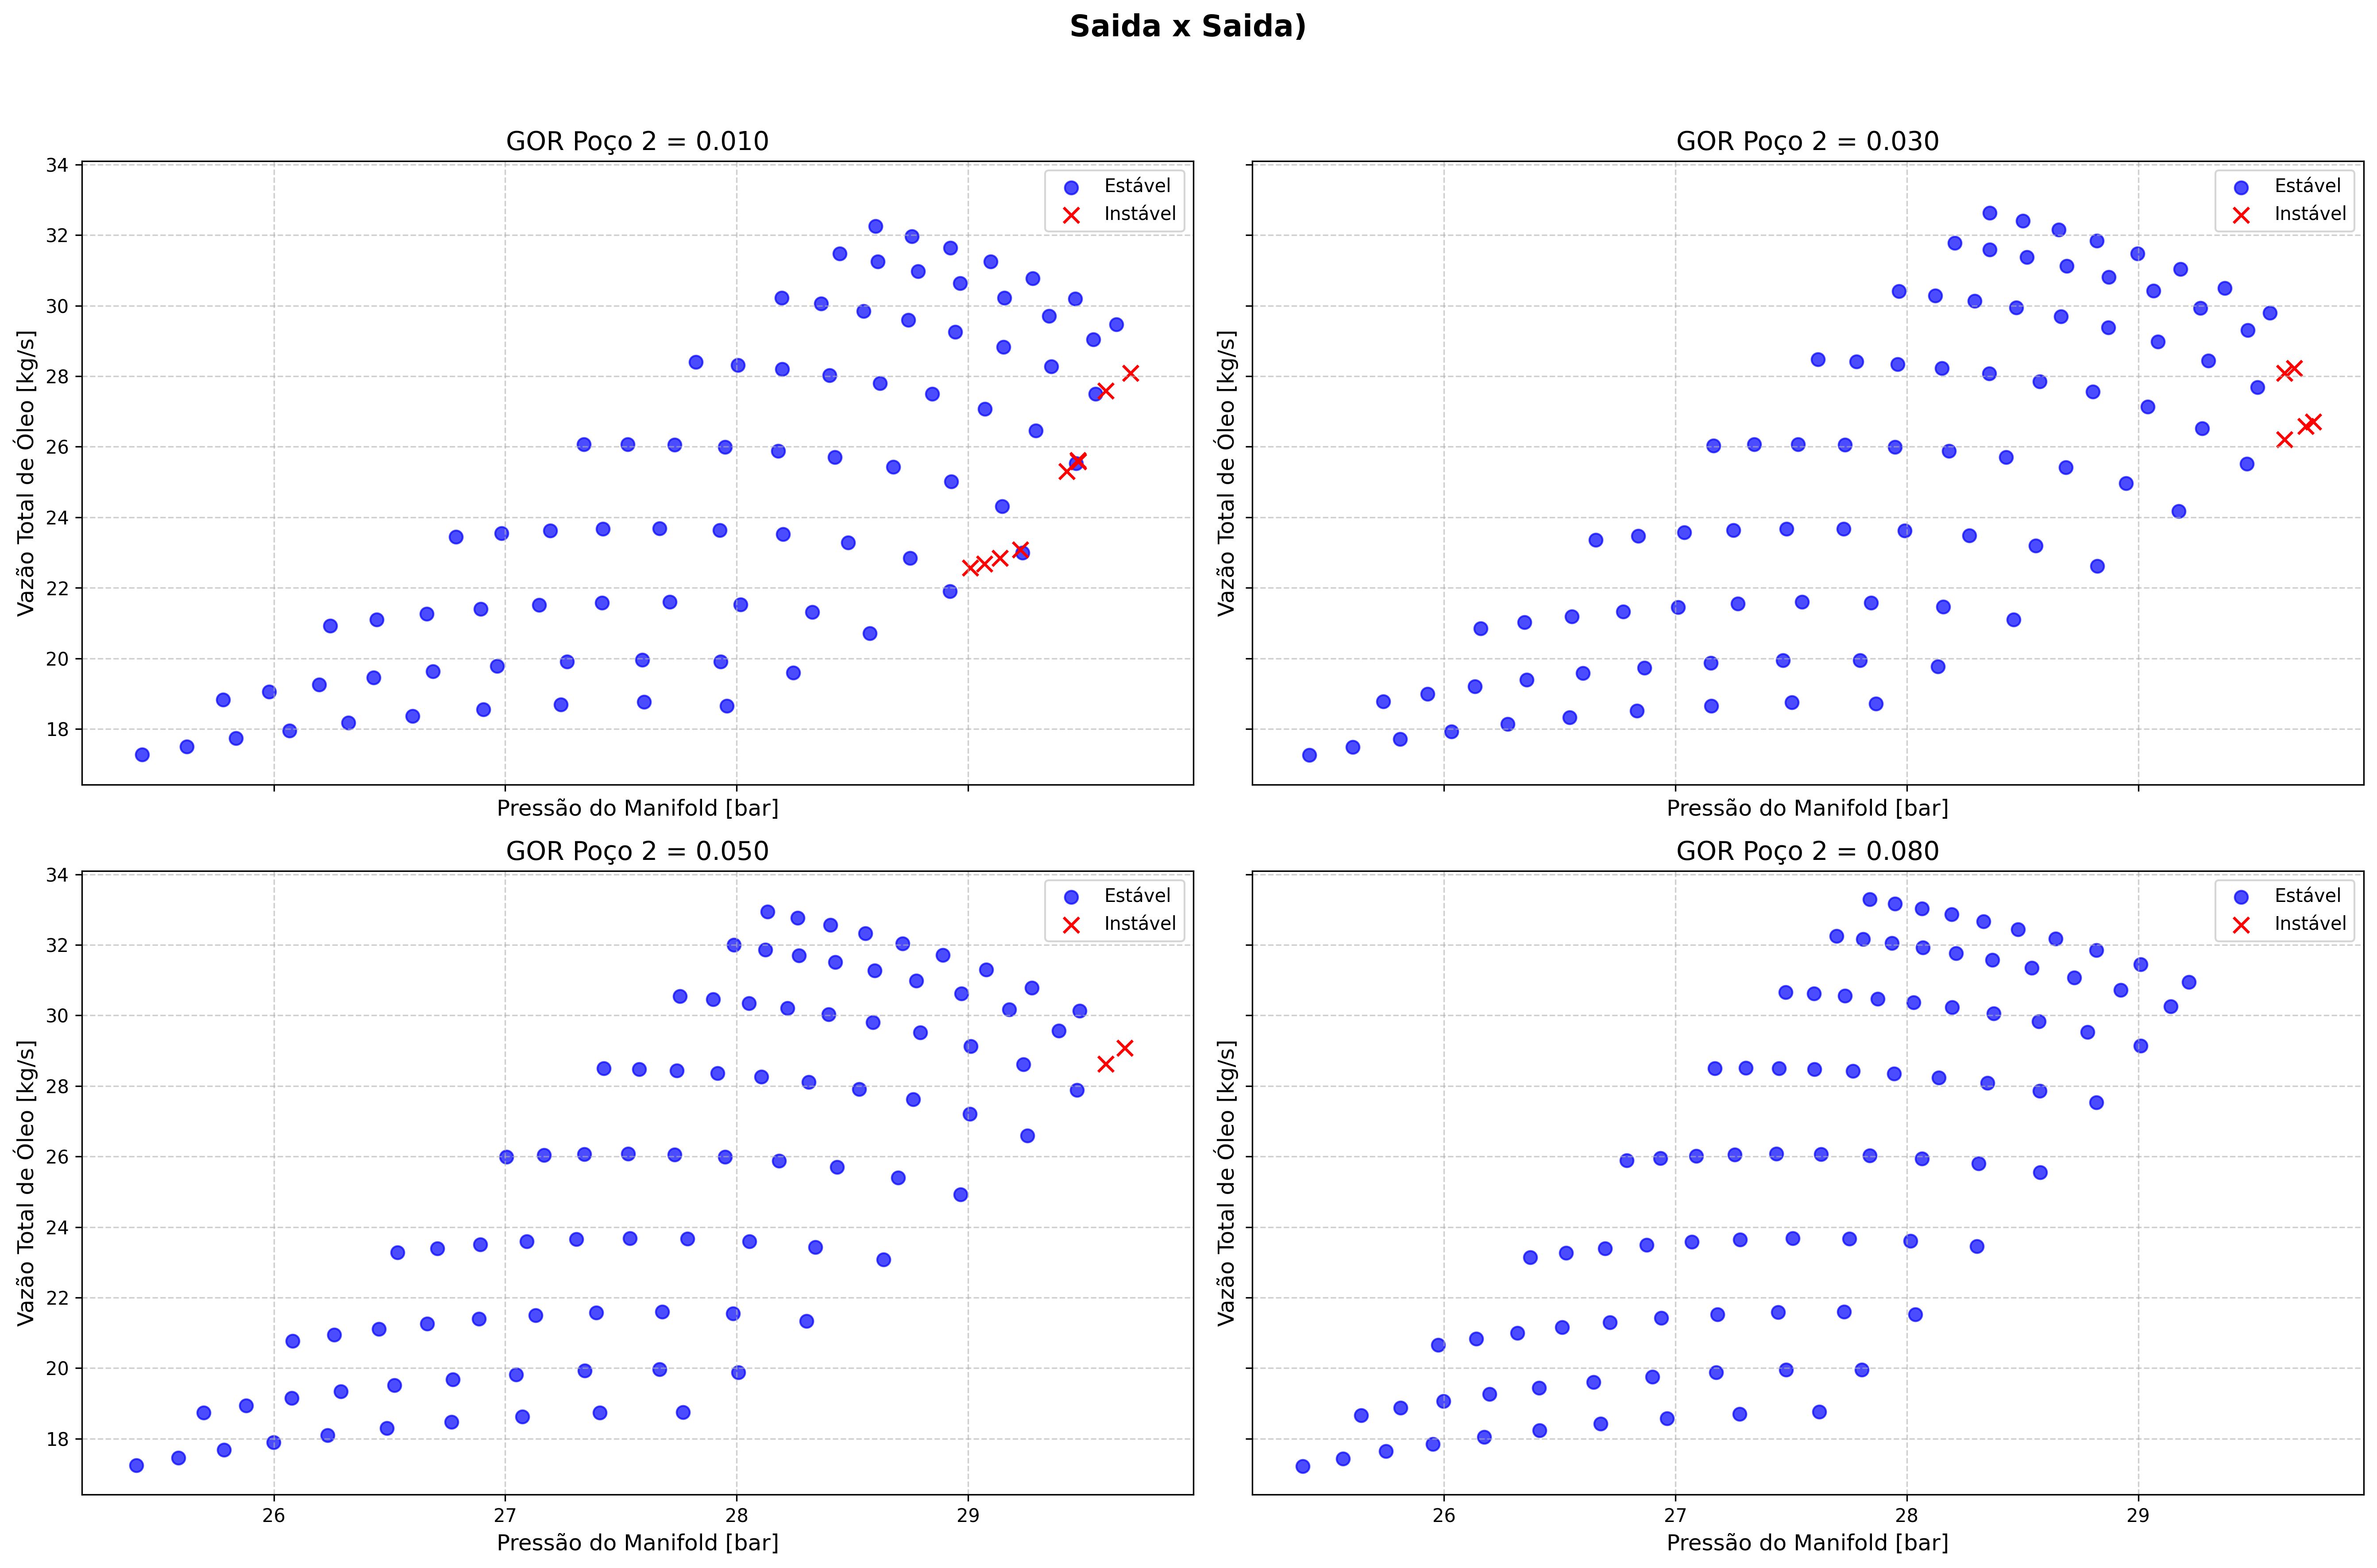

In [6]:
wgl2_rates = np.linspace(0.2, 2.0, 10)      
u2_openings = np.linspace(0.2, 1.0, 9)     
GOR2_values = [0.01, 0.03, 0.05, 0.08]      

# Parâmetros FIXOS para o Poço 2 
wgl1_fixed = 0.7   
u1_fixed = 1.0     
GOR1_fixed = 0.1  

# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]


tf = 30000     
dt = 5          
t = np.arange(0, tf, dt)
tolerance = 1e-7


x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)

dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)


resultados_finais = {}

passos = 3

for idx, gor2_val in enumerate(GOR2_values):
    print(f"--- Calculando mapa para GOR1 = {gor2_val:.3f} ---")
    stability_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    pm_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    wpo_total_map = np.zeros((len(wgl2_rates), len(u2_openings)))

    for i, wgl2 in enumerate(wgl2_rates):
        for j, u2 in enumerate(u2_openings):
            par_values = [wgl1_fixed, wgl2, u1_fixed, u2, GOR1_fixed, gor2_val]
            x_current = np.array(y0)
            contador = 0
            output_history= []
            stable_found = False

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()
                model_output = sw.modelo(x_next, par_values)
                output_history.append(model_output)

               
                delta = np.abs( x_current[6] - x_next[6])


                if delta <= tolerance:
                    contador += 1  
                else:
                    contador = 0   
                if contador >= passos:
                    stable_found = True
                  
                    break
                    
                x_current = x_next



            stability_map[i, j] = 1 if stable_found else 0
            
            #if stability_map[i,j] == 0:   
              #  print(u2,wgl2)
          
            if stable_found:
                final_pm = output_history[-1]['Pm']
                final_wpo = output_history[-1]['wto_riser']

            else:
                start_idx = int(len(output_history) * 0.2)
                last_section =([d['Pm'] for d in output_history[start_idx:]])
                final_pm = np.mean([d['Pm'] for d in output_history[start_idx:]])
                final_wpo = np.mean([d['wto_riser'] for d in output_history[start_idx:]])
                
                #print(ocilacao)
            pm_map[i, j] = final_pm
            wpo_total_map[i, j] = final_wpo
            
    resultados_finais[gor2_val] = {
        'stability': stability_map,
        'Pm': pm_map,
        'wto_riser': wpo_total_map
    }
# Define a quantidade de subplots com base no número de GORs

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Saida x Saida)', fontsize=16, weight='bold')

for idx, gor2_val in enumerate(GOR2_values):
    ax = axs[idx]
    mapas = resultados_finais[gor2_val]

    #Achata as matrizes 2D para vetores 1D 
    pm_values = mapas['Pm'].flatten()
    wpo_values = mapas['wto_riser'].flatten()
    stability_values = mapas['stability'].flatten()

    pm_stable = pm_values[stability_values == 1] / 1e5  # Converte para bar
    wpo_stable = wpo_values[stability_values == 1]
    
    pm_unstable = pm_values[stability_values == 0] / 1e5 # Converte para bar
    wpo_unstable = wpo_values[stability_values == 0]
  
    # Plota os pontos
    ax.scatter(pm_stable, wpo_stable, 
               s=50, color='blue', alpha=0.7, label='Estável')
    ax.scatter(pm_unstable, wpo_unstable, 
               s=70, color='red', marker='x', label='Instável')

    # Configurações do gráfico
    ax.set_title(f"GOR Poço 2 = {gor2_val:.3f}", fontsize=14)
    ax.set_xlabel("Pressão do Manifold [bar]", fontsize=12)
    ax.set_ylabel("Vazão Total de Óleo [kg/s]", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


--- Calculando mapa para GOR1 = 0.010 ---
Ponto Instável (u2=0.70, wgl2=0.20): Oscilação Relativa de Pm = 4.73%
Ponto Instável (u2=0.80, wgl2=0.20): Oscilação Relativa de Pm = 8.20%
Ponto Instável (u2=0.90, wgl2=0.20): Oscilação Relativa de Pm = 10.75%
Ponto Instável (u2=1.00, wgl2=0.20): Oscilação Relativa de Pm = 12.45%
Ponto Instável (u2=0.80, wgl2=0.40): Oscilação Relativa de Pm = 4.85%
Ponto Instável (u2=0.90, wgl2=0.40): Oscilação Relativa de Pm = 7.42%
Ponto Instável (u2=1.00, wgl2=0.40): Oscilação Relativa de Pm = 9.17%
Ponto Instável (u2=0.90, wgl2=0.60): Oscilação Relativa de Pm = 0.10%
Ponto Instável (u2=1.00, wgl2=0.60): Oscilação Relativa de Pm = 6.73%
--- Calculando mapa para GOR1 = 0.030 ---
Ponto Instável (u2=0.80, wgl2=0.20): Oscilação Relativa de Pm = 2.29%
Ponto Instável (u2=0.90, wgl2=0.20): Oscilação Relativa de Pm = 3.86%
Ponto Instável (u2=1.00, wgl2=0.20): Oscilação Relativa de Pm = 5.10%
Ponto Instável (u2=0.90, wgl2=0.40): Oscilação Relativa de Pm = 3.16%
Pont

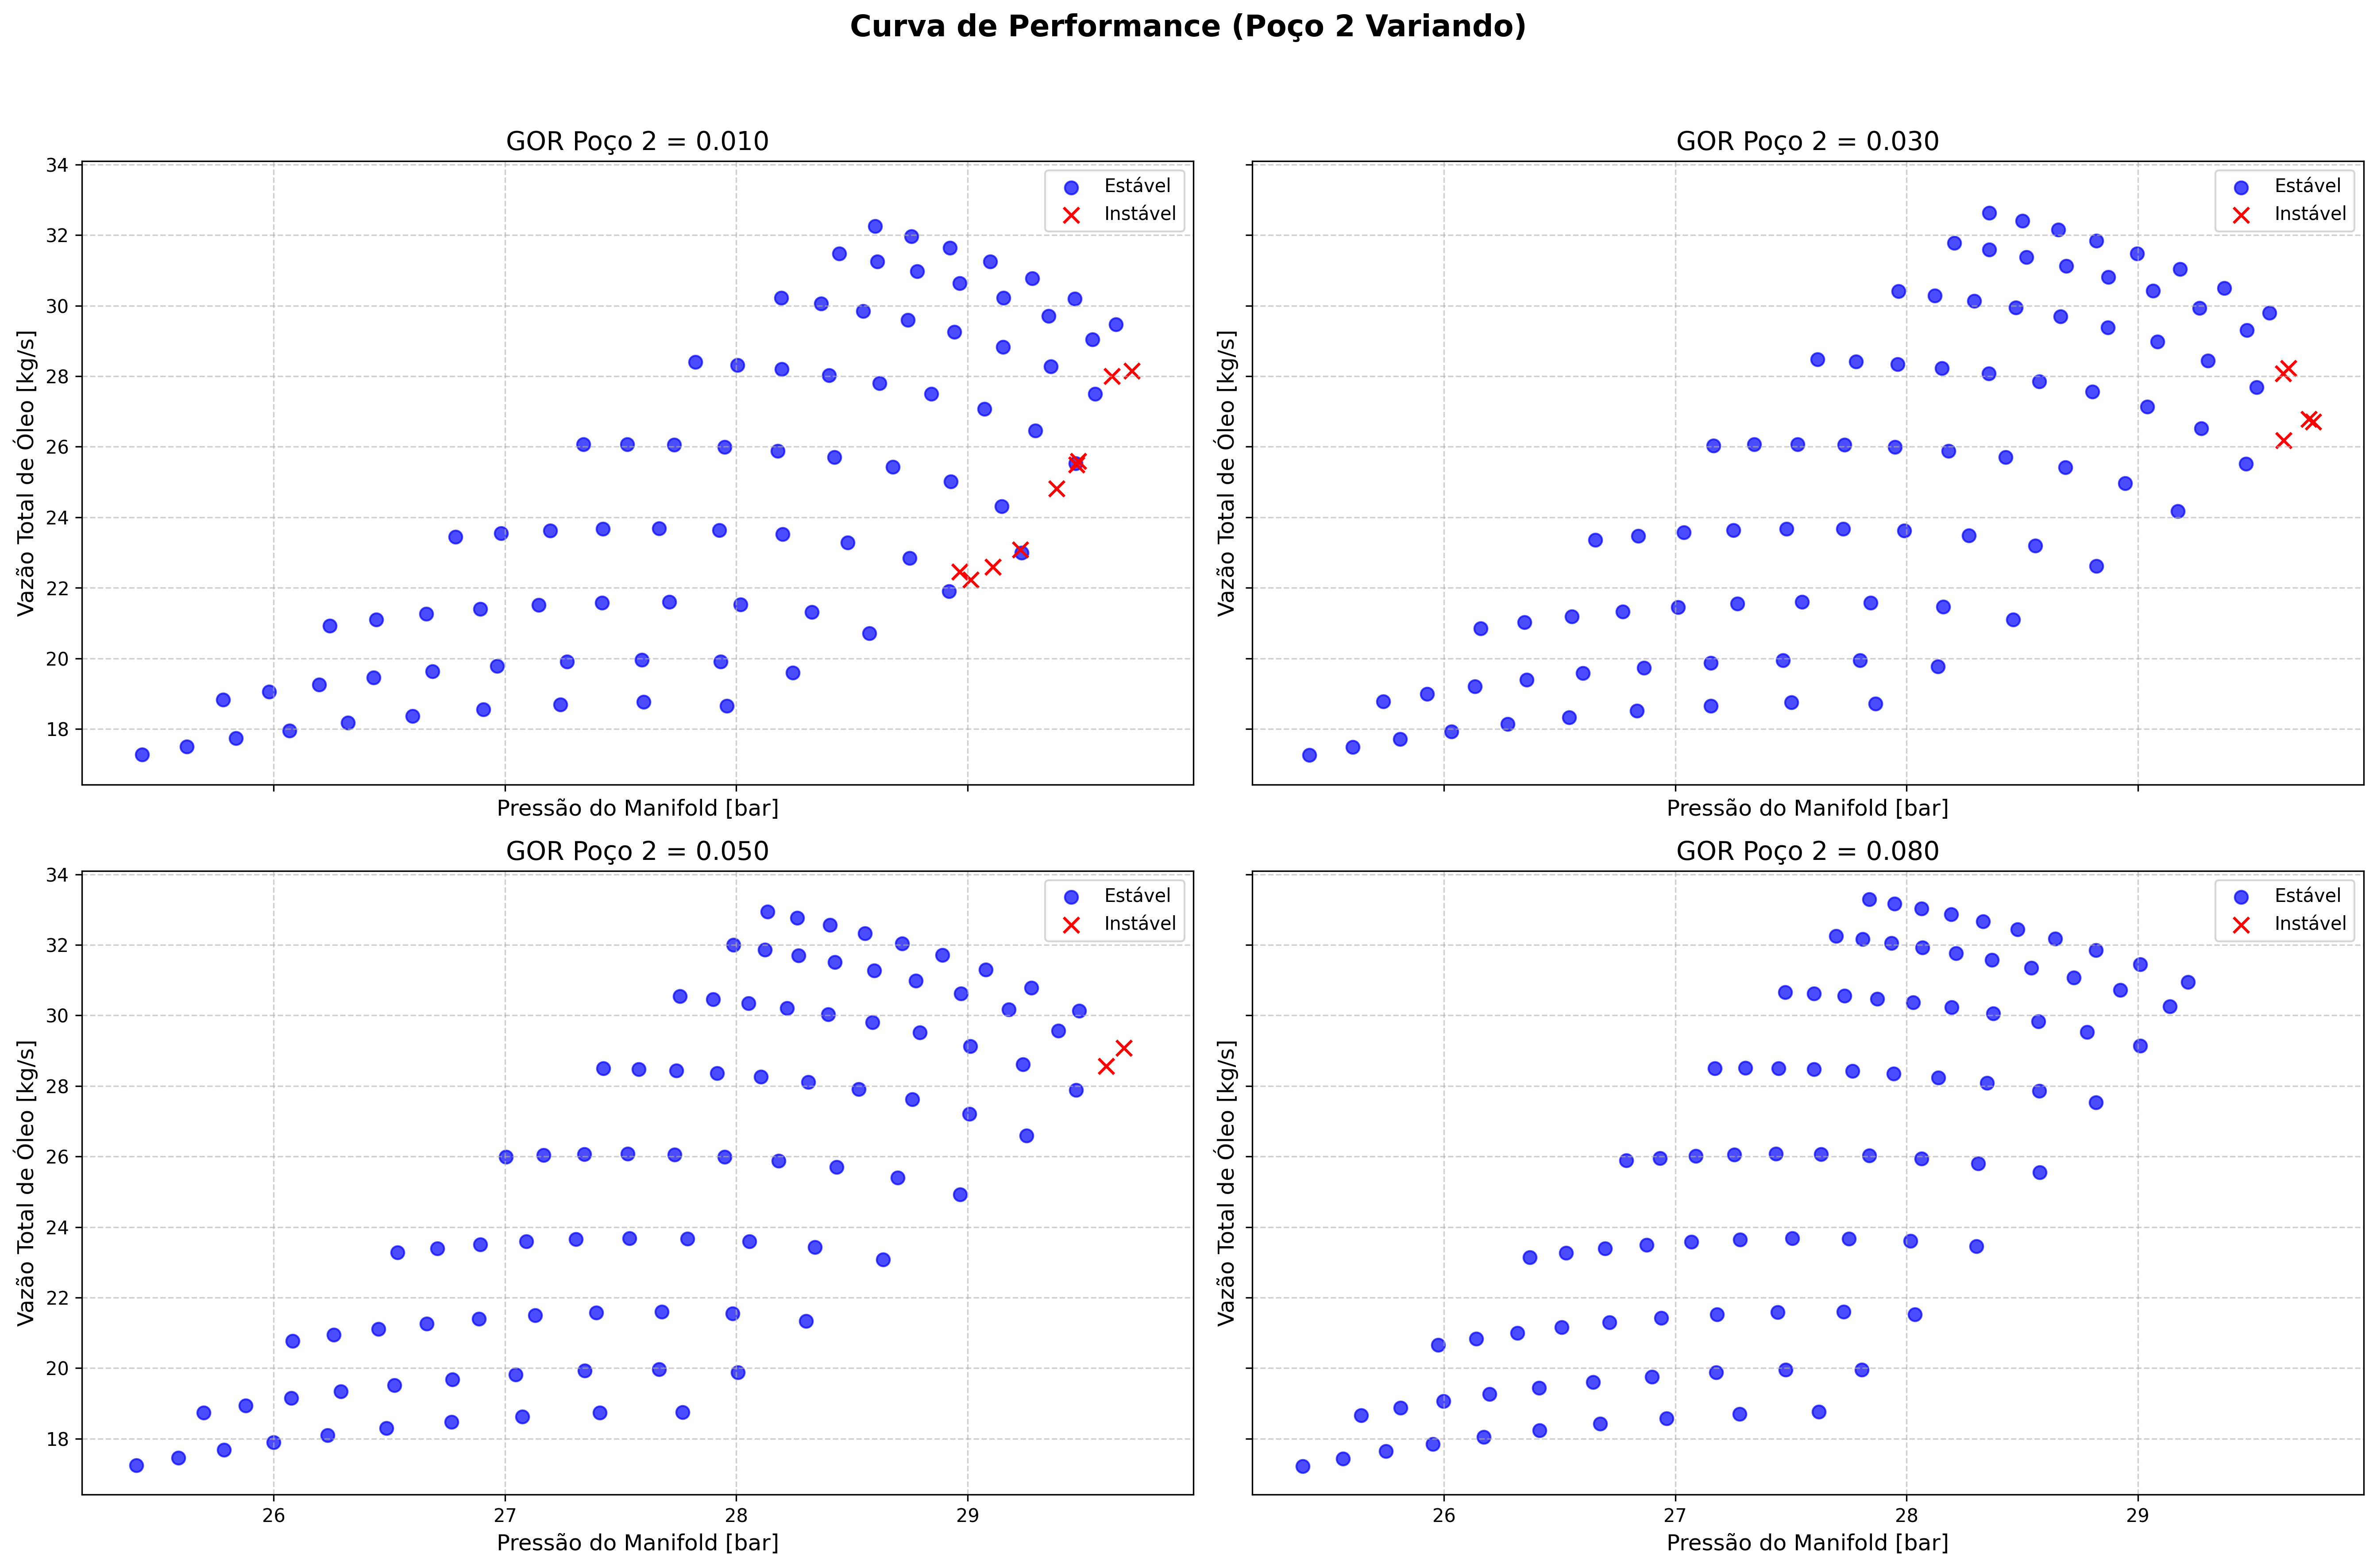

In [7]:
wgl2_rates = np.linspace(0.2, 2.0, 10)      
u2_openings = np.linspace(0.2, 1.0, 9)     
GOR2_values = [0.01, 0.03, 0.05, 0.08]      

# Parâmetros FIXOS para o Poço 2 
wgl1_fixed = 0.7   
u1_fixed = 1.0     
GOR1_fixed = 0.1  

# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]


tf = 30000     
dt = 5          
t = np.arange(0, tf, dt)
tolerance = 1e-7


x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)

dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)


resultados_finais = {}

passos = 3

for idx, gor2_val in enumerate(GOR2_values):
    print(f"--- Calculando mapa para GOR1 = {gor2_val:.3f} ---")
    stability_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    pm_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    wpo_total_map = np.zeros((len(wgl2_rates), len(u2_openings)))

    for i, wgl2 in enumerate(wgl2_rates):
        for j, u2 in enumerate(u2_openings):
            par_values = [wgl1_fixed, wgl2, u1_fixed, u2, GOR1_fixed, gor2_val]
            x_current = np.array(y0)
            contador = 0
            output_history= []
            stable_found = False

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()
                model_output = sw.modelo(x_next, par_values)
                output_history.append(model_output)

               
                delta = np.abs( x_current[6] - x_next[6])


                if delta <= tolerance:
                    contador += 1  
                else:
                    contador = 0   
                if contador >= passos:
                    stable_found = True
                  
                    break
                    
                x_current = x_next
            
            # --- LÓGICA DE CÁLCULO E PRINT CORRIGIDA ---
            stability_map[i, j] = 1 if stable_found else 0

            if stable_found:
                final_pm = output_history[-1]['Pm']
                final_wpo = output_history[-1]['wto_riser']
            else:
                # 1. Calcula o índice inicial (PRIMEIRO)
                start_idx = int(len(output_history) * 0.6)
                
                # 2. Pega a última seção dos dados de pressão
                last_section_pm = [d['Pm'] for d in output_history[start_idx:]]
                
                # Evita erro se a lista estiver vazia (simulação muito curta)
                if not last_section_pm:
                    final_pm = 0
                    ocilacao_relativa = 0
                else:
                    # 3. Calcula a média e a oscilação
                    final_pm = np.mean(last_section_pm)
                    # Adiciona uma pequena constante para evitar divisão por zero
                    ocilacao_relativa = (max(last_section_pm) - min(last_section_pm)) / (final_pm + 1e-9)

                # 4. IMPRIME A OSCILAÇÃO PARA O PONTO INSTÁVEL
                print(f"Ponto Instável (u2={u2:.2f}, wgl2={wgl2:.2f}): Oscilação Relativa de Pm = {ocilacao_relativa:.2%}")

                # 5. Calcula a vazão média
                last_section_wpo = [d['wto_riser'] for d in output_history[start_idx:]]
                final_wpo = np.mean(last_section_wpo) if last_section_wpo else 0

            # Armazena os resultados nos mapas
            pm_map[i, j] = final_pm
            wpo_total_map[i, j] = final_wpo
            
    # Armazena os resultados para o GOR atual
    resultados_finais[gor2_val] = {
        'stability': stability_map,
        'Pm': pm_map,
        'wto_riser': wpo_total_map
    }

# ==============================================================================
# 3. PLOTAGEM (sem alterações)
# ==============================================================================
print("\n--- Gerando o gráfico de Curva de Performance do Sistema ---")
# O código de plotagem já estava correto e pode ser mantido

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

# --- Cria a figura com alta resolução (DPI) ---
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Curva de Performance (Poço 2 Variando)', fontsize=16, weight='bold')

for idx, gor2_val in enumerate(GOR2_values):
    ax = axs[idx]
    mapas = resultados_finais[gor2_val]

    pm_values = mapas['Pm'].flatten()
    wpo_values = mapas['wto_riser'].flatten()
    stability_values = mapas['stability'].flatten()

    pm_stable = pm_values[stability_values == 1] / 1e5
    wpo_stable = wpo_values[stability_values == 1]
    
    pm_unstable = pm_values[stability_values == 0] / 1e5
    wpo_unstable = wpo_values[stability_values == 0]
    
    ax.scatter(pm_stable, wpo_stable, s=50, color='blue', alpha=0.7, label='Estável')
    ax.scatter(pm_unstable, wpo_unstable, s=70, color='red', marker='x', label='Instável')

    ax.set_title(f"GOR Poço 2 = {gor2_val:.3f}", fontsize=14)
    ax.set_xlabel("Pressão do Manifold [bar]", fontsize=12)
    ax.set_ylabel("Vazão Total de Óleo [kg/s]", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- Calculando mapa para GOR2 = 0.010 ---
  -> Ponto instável (u2=0.70, wgl2=0.20). Oscilação de Pm: 4.90%
  -> Ponto instável (u2=0.80, wgl2=0.20). Oscilação de Pm: 8.52%
  -> Ponto instável (u2=0.90, wgl2=0.20). Oscilação de Pm: 10.94%
  -> Ponto instável (u2=1.00, wgl2=0.20). Oscilação de Pm: 13.29%
  -> Ponto instável (u2=0.80, wgl2=0.40). Oscilação de Pm: 4.93%
  -> Ponto instável (u2=0.90, wgl2=0.40). Oscilação de Pm: 7.49%
  -> Ponto instável (u2=1.00, wgl2=0.40). Oscilação de Pm: 9.20%
  -> Ponto instável (u2=0.90, wgl2=0.60). Oscilação de Pm: 2.94%
  -> Ponto instável (u2=1.00, wgl2=0.60). Oscilação de Pm: 6.75%


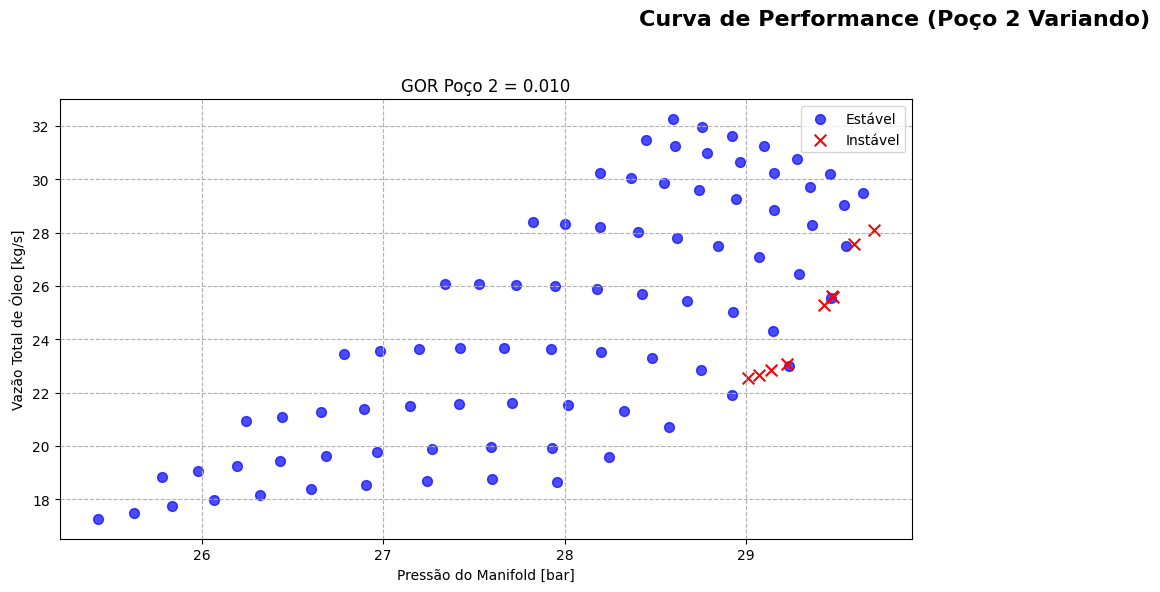

In [8]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt


# ==============================================================================
# 1. CONFIGURAÇÃO INICIAL
# ==============================================================================
wgl2_rates = np.linspace(0.2, 2.0, 10)
u2_openings = np.linspace(0.2, 1.0, 9)
GOR2_values = [0.01]

wgl1_fixed = 0.7
u1_fixed = 1.0
GOR1_fixed = 0.1

y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]
tf, dt, tolerance, passos = 30000, 5, 1e-7, 3
t = np.arange(0, tf, dt)

# --- Integrador CasADi ---
x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)
dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)

# ==============================================================================
# 2. LOOP PRINCIPAL DE SIMULAÇÃO
# ==============================================================================
resultados_finais = {}

for idx, gor2_val in enumerate(GOR2_values):
    print(f"--- Calculando mapa para GOR2 = {gor2_val:.3f} ---")
    stability_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    pm_map = np.zeros((len(wgl2_rates), len(u2_openings)))
    wpo_total_map = np.zeros((len(wgl2_rates), len(u2_openings)))

    for i, wgl2 in enumerate(wgl2_rates):
        for j, u2 in enumerate(u2_openings):
            par_values = [wgl1_fixed, wgl2, u1_fixed, u2, GOR1_fixed, gor2_val]
            x_current = np.array(y0)
            contador, stable_found = 0, False
            output_history = []

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()
                model_output = sw.modelo(x_next, par_values)
                output_history.append(model_output)

                delta = np.abs(x_current[6] - x_next[6])
                if delta <= tolerance:
                    contador += 1
                else:
                    contador = 0
                if contador >= passos:
                    stable_found = True
                    break
                x_current = x_next

            stability_map[i, j] = 1 if stable_found else 0

            if stable_found:
                final_pm = output_history[-1]['Pm']
                final_wpo = output_history[-1]['wto_riser']
            else:
                # ###############################################################
                # # INÍCIO DA LÓGICA DE OSCILAÇÃO CORRIGIDA (ALTERAÇÃO MÍNIMA)  #
                # ###############################################################
                start_idx = int(len(output_history) * 0.2)
                
                # Pega a seção final de dados para as duas variáveis
                last_section_pm = [d['Pm'] for d in output_history[start_idx:]]
                last_section_wpo = [d['wto_riser'] for d in output_history[start_idx:]]

                # Garante que há dados para analisar
                if last_section_pm:
                    # Calcula a média da pressão
                    final_pm = np.mean(last_section_pm)
                    # Calcula a oscilação relativa da pressão
                    oscilacao_pm = (max(last_section_pm) - min(last_section_pm)) / (final_pm + 1e-9)
                    # Imprime a oscilação formatada como porcentagem
                    print(f"  -> Ponto instável (u2={u2:.2f}, wgl2={wgl2:.2f}). Oscilação de Pm: {oscilacao_pm:.2%}")
                else:
                    # Caso de segurança se a simulação for muito curta
                    final_pm = 0

                # Calcula a vazão média (sempre necessário para o mapa)
                final_wpo = np.mean(last_section_wpo) if last_section_wpo else 0
                # ###############################################################
                # # FIM DA LÓGICA DE OSCILAÇÃO CORRIGIDA                          #
                # ###############################################################

            # Preenche os mapas de resultados
            pm_map[i, j] = final_pm
            wpo_total_map[i, j] = final_wpo

    resultados_finais[gor2_val] = {
        'stability': stability_map,
        'Pm': pm_map,
        'wto_riser': wpo_total_map
    }
    
# ==============================================================================
# 3. PLOTAGEM (COM PEQUENA CORREÇÃO)
# ==============================================================================
# Pequena correção: n_gor deve usar GOR2_values, não GOR1_values
n_gor = len(GOR2_values)
ncols = 2 # Definindo 2 colunas para o layout
nrows = int(np.ceil(n_gor / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 6 * nrows), squeeze=False)
axs = axs.flatten()
fig.suptitle('Curva de Performance (Poço 2 Variando)', fontsize=16, weight='bold')

for idx, gor2_val in enumerate(GOR2_values):
    ax = axs[idx]
    mapas = resultados_finais[gor2_val]

    pm_values = mapas['Pm'].flatten()
    wpo_values = mapas['wto_riser'].flatten()
    stability_values = mapas['stability'].flatten()

    pm_stable = pm_values[stability_values == 1] / 1e5
    wpo_stable = wpo_values[stability_values == 1]
    
    pm_unstable = pm_values[stability_values == 0] / 1e5
    wpo_unstable = wpo_values[stability_values == 0]

    ax.scatter(pm_stable, wpo_stable, s=50, color='blue', alpha=0.7, label='Estável')
    ax.scatter(pm_unstable, wpo_unstable, s=70, color='red', marker='x', label='Instável')

    ax.set_title(f"GOR Poço 2 = {gor2_val:.3f}")
    ax.set_xlabel("Pressão do Manifold [bar]")
    ax.set_ylabel("Vazão Total de Óleo [kg/s]")
    ax.grid(True, linestyle='--'), ax.legend()

# Esconde eixos não utilizados
for k in range(n_gor, len(axs)):
    fig.delaxes(axs[k])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()